# Sistemas de recomendación
### Carga de datos de Movie Lens

In [1]:
import pandas as pd

In [7]:
df = pd.read_csv("../datasets/ml-100k/u.data.csv", sep="\t", header=None)

In [8]:
type(df)

pandas.core.frame.DataFrame

In [9]:
df.head()

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [11]:
df.shape

(100000, 4)

In [13]:
df.columns = ["UserID", "ItemID", "Rating", "TimeStamp"]

In [14]:
df.head()

,UserID,ItemID,Rating,TimeStamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Análisis exploratorio de los ítems

In [15]:
import matplotlib.pyplot as plt

(array([ 6110.,     0., 11370.,     0.,     0., 27145.,     0., 34174.,
            0., 21201.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

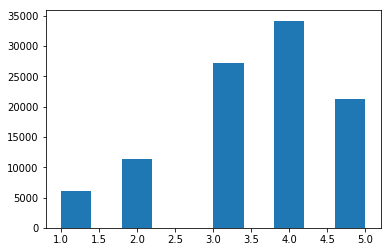

In [16]:
plt.hist(df.Rating)

(array([11459.,  5724., 19359.,  9315.,  9396., 10083.,  6175.,  9603.,
        10048.,  8838.]),
 array([8.74724710e+08, 8.76580903e+08, 8.78437096e+08, 8.80293288e+08,
        8.82149481e+08, 8.84005674e+08, 8.85861867e+08, 8.87718060e+08,
        8.89574252e+08, 8.91430445e+08, 8.93286638e+08]),
 <a list of 10 Patch objects>)

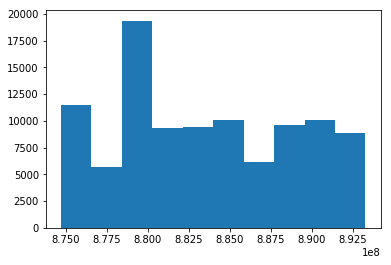

In [17]:
plt.hist(df.TimeStamp)

In [18]:
df.groupby(["Rating"])["UserID"].count()

Rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: UserID, dtype: int64

(array([1.146e+03, 2.490e+02, 1.390e+02, 6.700e+01, 3.800e+01, 2.400e+01,
        7.000e+00, 5.000e+00, 6.000e+00, 1.000e+00]),
 array([  1. ,  59.2, 117.4, 175.6, 233.8, 292. , 350.2, 408.4, 466.6,
        524.8, 583. ]),
 <a list of 10 Patch objects>)

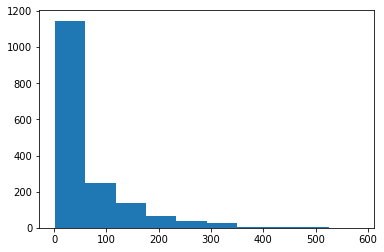

In [28]:
plt.hist(df.groupby(["ItemID"])["ItemID"].count())

### Representación en forma matricial

In [33]:
import numpy as np

In [30]:
n_users = df.UserID.unique().shape[0]
n_users

943

In [31]:
n_items = df.ItemID.unique().shape[0]
n_items

1682

In [34]:
ratings = np.zeros((n_users, n_items))

In [35]:
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

In [36]:
type(ratings)

numpy.ndarray

In [37]:
ratings.shape

(943, 1682)

In [38]:
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [41]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0]*ratings.shape[1])
sparsity *= 100
print("Coeficiente de sparseidad: {:4.2f}%".format(sparsity))

Coeficiente de sparseidad: 6.30%


### Crear conjuntos de entrenamiento y validación

In [42]:
from sklearn.cross_validation import train_test_split

In [43]:
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.3, random_state=42)

In [44]:
ratings_train.shape

(660, 1682)

In [45]:
ratings_test.shape

(283, 1682)

## Filtro colaborativo basado en Usuarios
* Matriz de similaridad entre los usuarios (distancia del coseno).
* Predecir la valoración desconocida de un ítem *i* para un usuario activo *u* basandonos en la suma ponderada de todas las valoraciones del resto de usuarios para dicho ítem.
* Recomendaremos los nuevos ítems a los usuarios según lo establecido en los pasos anteriores.

In [46]:
import numpy as np
import sklearn

In [47]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_train)

In [48]:
type(sim_matrix)

numpy.ndarray

In [49]:
sim_matrix.shape

(660, 660)

In [50]:
sim_matrix

array([[1.        , 0.17448349, 0.18009754, ..., 0.13331459, 0.17695593,
        0.21882481],
       [0.17448349, 1.        , 0.07993097, ..., 0.07175808, 0.09552622,
        0.05512655],
       [0.18009754, 0.07993097, 1.        , ..., 0.0191736 , 0.02233385,
        0.10310785],
       ...,
       [0.13331459, 0.07175808, 0.0191736 , ..., 1.        , 0.04853428,
        0.05142508],
       [0.17695593, 0.09552622, 0.02233385, ..., 0.04853428, 1.        ,
        0.1198022 ],
       [0.21882481, 0.05512655, 0.10310785, ..., 0.05142508, 0.1198022 ,
        1.        ]])

In [51]:
users_predictions = sim_matrix.dot(ratings_train) / np.array([np.abs(sim_matrix).sum(axis=1)]).T

In [52]:
users_predictions

array([[2.10259747e+00, 5.86975978e-01, 3.40264192e-01, ...,
        0.00000000e+00, 7.33611460e-03, 6.04379414e-03],
       [1.40999723e+00, 2.91863934e-01, 2.68085289e-01, ...,
        0.00000000e+00, 3.50378592e-03, 2.32963985e-03],
       [1.69014833e+00, 3.13648440e-01, 3.26127887e-01, ...,
        0.00000000e+00, 3.25391767e-03, 1.77210119e-03],
       ...,
       [1.73393747e+00, 4.06719333e-01, 3.21166908e-01, ...,
        0.00000000e+00, 2.71269625e-03, 9.00511411e-03],
       [2.34361031e+00, 8.10544770e-01, 4.73941025e-01, ...,
        0.00000000e+00, 1.01130066e-02, 9.66427605e-03],
       [2.36796969e+00, 5.98146138e-01, 3.85569804e-01, ...,
        0.00000000e+00, 6.39996638e-03, 5.37442746e-03]])

In [53]:
from sklearn.metrics import mean_squared_error

In [157]:
def get_mse(preds, actuals):
    if preds.shape[0] != actuals.shape[0]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

In [55]:
get_mse(users_predictions, ratings_train)

7.878218313143215

In [56]:
get_mse(users_predictions, ratings_test)

8.745164067978985

## Filtro colaborativo basado en los KNN

In [57]:
from sklearn.neighbors import NearestNeighbors

In [87]:
k = 5

In [88]:
neighbors = NearestNeighbors(k, 'cosine')

In [89]:
neighbors.fit(ratings_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius='cosine')

In [90]:
top_k_distances, top_k_users = neighbors.kneighbors(ratings_train, return_distance=True)

In [91]:
top_k_distances.shape

(660, 5)

In [92]:
top_k_distances[0]

array([ 0.        , 41.71330723, 43.3474336 , 45.04442252, 45.04442252])

In [93]:
top_k_users.shape

(660, 5)

In [94]:
top_k_users[0]

array([  0, 211,  16, 583, 428])

In [95]:
users_predicts_k = np.zeros(ratings_train.shape)
for i in range(ratings_train.shape[0]):# para cada usuario del conjunto de entrenamiento
    users_predicts_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i]) / np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T

In [96]:
users_predicts_k.shape

(660, 1682)

In [97]:
users_predicts_k

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.74469557, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.9753676 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [98]:
get_mse(users_predicts_k, ratings_train)

8.180803170774984

In [99]:
get_mse(users_predicts_k, ratings_test)

11.338914012692959

## Filtro colaborativo basado en Items

In [100]:
n_movies = ratings_train.shape[1]
n_movies

1682

In [101]:
neighbors = NearestNeighbors(n_movies, 'cosine')

In [102]:
neighbors.fit(ratings_train.T)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=1682, p=2,
         radius='cosine')

In [106]:
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

In [104]:
top_k_distances.shape

(1682, 1682)

In [119]:
top_k_distances

array([[ 0.        , 53.12249994, 54.38749856, ..., 77.08436936,
        77.39509028, 79.3473377 ],
       [ 0.        , 27.        , 27.29468813, ..., 72.18032973,
        75.65712128, 80.0874522 ],
       [ 0.        , 24.77902339, 25.05992817, ..., 72.09022125,
        75.27283707, 83.11437902],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 77.12976079,
        80.79603951, 88.63407922],
       [ 0.        ,  1.        ,  3.        , ..., 76.99350622,
        80.7403245 , 88.51553536],
       [ 0.        ,  1.        ,  3.        , ..., 77.03246069,
        80.66597796, 88.51553536]])

In [108]:
top_k_items.shape

(1682, 1682)

In [114]:
top_k_items

array([[   0,  120,  404, ...,  285,  312,  301],
       [   1,  575,  232, ...,  257,   99,   49],
       [   2,  742, 1094, ...,  180,   99,   49],
       ...,
       [1565, 1571, 1570, ...,  180,   99,   49],
       [1680, 1671, 1582, ...,  180,   99,   49],
       [1681, 1596, 1592, ...,  180,   99,   49]])

In [109]:
item_preds = ratings_train.dot(top_k_distances) / np.array([np.abs(top_k_distances).sum(axis=1)])

In [110]:
item_preds.shape

(660, 1682)

In [111]:
item_preds

array([[0.        , 0.31842643, 0.37009323, ..., 1.44850442, 1.4566397 ,
        1.54530823],
       [0.        , 0.0545379 , 0.06227954, ..., 0.20078701, 0.20112087,
        0.21332472],
       [0.        , 0.03522479, 0.04073126, ..., 0.18456903, 0.18654661,
        0.20076303],
       ...,
       [0.        , 0.08968346, 0.10313623, ..., 0.42050197, 0.4196067 ,
        0.45863507],
       [0.        , 0.25835756, 0.29918119, ..., 1.31043371, 1.32278067,
        1.41390683],
       [0.        , 0.07174777, 0.08538024, ..., 0.25535196, 0.25259645,
        0.26199652]])

In [112]:
get_mse(item_preds, ratings_train)

11.172565375125632

In [113]:
get_mse(item_preds, ratings_test)

11.876775601508902

### Filtrado colaborativo basado en KNN

In [120]:
k = 30
neighbors = NearestNeighbors(k, 'cosine')
neighbors.fit(ratings_train.T)
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

In [121]:
top_k_distances.shape

(1682, 30)

In [122]:
top_k_items[0]

array([  0, 120, 404, 116, 221, 150, 117, 180,   6, 741,  27,  94, 256,
       236, 124,  81,  24, 587, 227, 110, 234,  78, 203, 545,  70,  14,
        68, 596,  49, 143])

In [123]:
top_k_distances[0]

array([ 0.        , 53.12249994, 54.38749856, 55.50675635, 56.49778757,
       56.9473441 , 57.21013896, 57.81003373, 58.10335619, 58.16356248,
       58.19793811, 58.37807808, 58.70264049, 58.83876273, 58.97457079,
       59.52310476, 59.61543424, 59.84981203, 59.89156869, 59.94163828,
       60.15812497, 60.35726965, 60.37383539, 60.63002556, 60.86049622,
       61.11464636, 61.31883887, 61.37589103, 61.57109712, 61.80614856])

In [139]:
preds = np.zeros(ratings_train.T.shape)
for i in range(ratings_train.T.shape[0]):
    if(i%50==0):
        print("iter "+str(i))
    den = 1
    if (np.abs(top_k_distances[i]).sum(axis=0)>0):
        den = np.abs(top_k_distances[i]).sum(axis=0)
    preds[i, :] = top_k_distances[i].dot(ratings_train.T[top_k_items][i])/np.array([den]).T

iter0
iter50
iter100
iter150
iter200
iter250
iter300
iter350
iter400
iter450
iter500
iter550
iter600
iter650
iter700
iter750
iter800
iter850
iter900
iter950
iter1000
iter1050
iter1100
iter1150
iter1200
iter1250
iter1300
iter1350
iter1400
iter1450
iter1500
iter1550
iter1600
iter1650


In [158]:
get_mse(preds, ratings_train)

8.732017359673444

In [159]:
get_mse(preds, ratings_test)

11.569842429886506

In [152]:
preds.shape

(1682, 660)

In [153]:
ratings_train.shape

(660, 1682)

In [154]:
ratings_test.shape

(283, 1682)